In [79]:
import os
import random
import numpy as np
from itertools import groupby
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
import librosa
import librosa.display

In [2]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [3]:
sample_rate = 16000

def load_wav_16k_mono(filename):
    global sample_rate
    file_contents = tf.io.read_file(filename)
    wav, old_sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    old_sample_rate = tf.cast(old_sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=old_sample_rate, rate_out=sample_rate)
    return wav

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

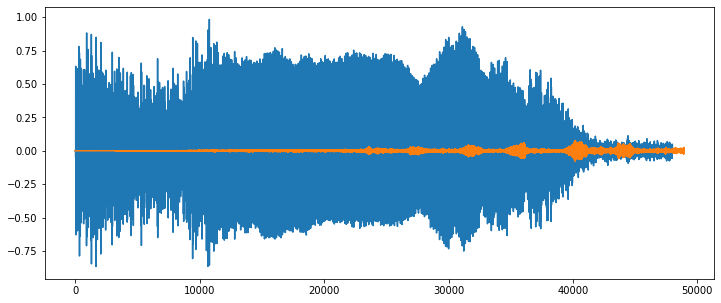

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(wave)
plt.plot(nwave)

In [6]:
POS_PATH = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG_PATH = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
pos = tf.data.Dataset.list_files(POS_PATH + '\*.wav')
neg = tf.data.Dataset.list_files(NEG_PATH + '\*.wav')

In [7]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
dataset = positives.concatenate(negatives)

In [8]:
lengths = []
for file in os.listdir(POS_PATH):
    tensor_wave = load_wav_16k_mono(os.path.join(POS_PATH, file))
    lengths.append(tensor_wave.shape[0])

In [10]:
tf.math.reduce_mean(lengths)/sample_rate
tf.math.reduce_max(lengths)/sample_rate
tf.math.reduce_min(lengths)/sample_rate
print(f'Mean length: {tf.math.reduce_mean(lengths)/sample_rate}s')
print(f'Max length: {tf.math.reduce_max(lengths)/sample_rate}s')
print(f'Min length: {tf.math.reduce_min(lengths)/sample_rate}s')

Mean length: 3.38475s
Max length: 5.0s
Min length: 2.0s


In [19]:
# draw spectrogram from .wav audio file
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=160, frame_step=64)  # increase frame_length to get more details
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Example of a random positive:


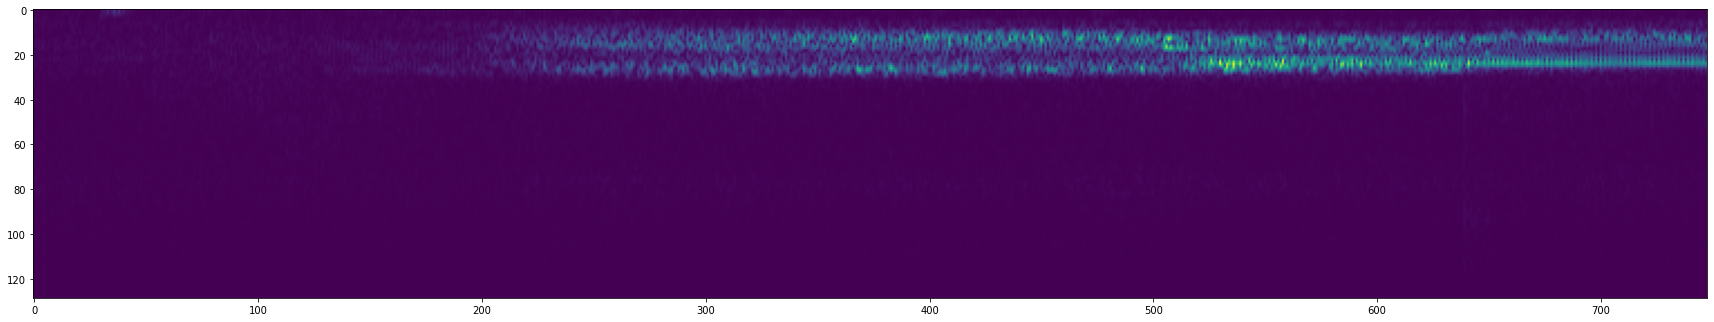

In [13]:
print('Example of a random positive:')
file_path, label = positives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(file_path, label)
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Example of a random negative:


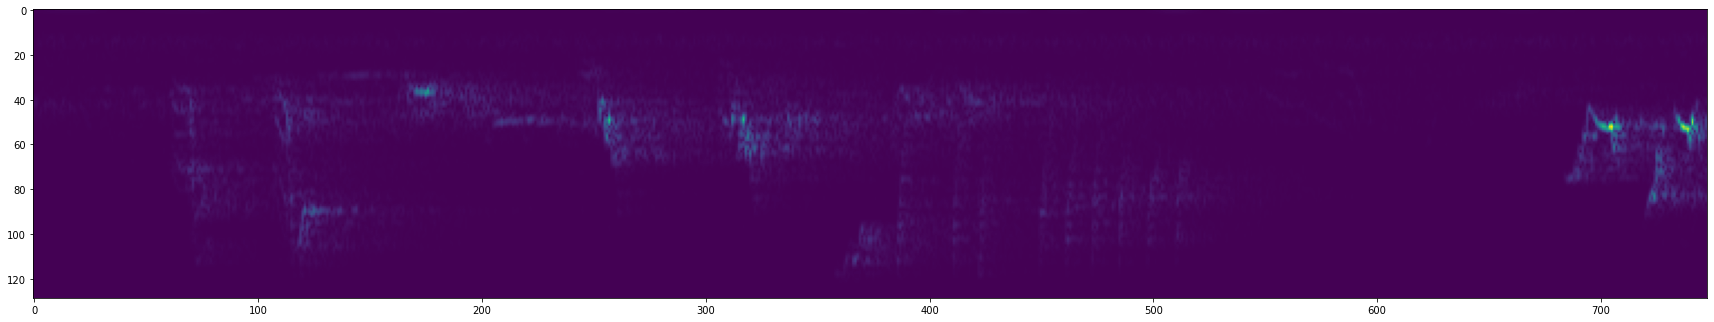

In [15]:
print('Example of a random negative:')
file_path, label = negatives.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram, label = preprocess(file_path, label)
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [16]:
# data pipeline
dataset = dataset.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
# train test split
train = dataset.take(int(len(dataset)*0.7))
test = dataset.skip(int(len(dataset)*0.7)).take(len(dataset)-int(len(dataset)*0.7))

In [20]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 748, 129, 1)

In [23]:
# Convolutional Neural Network
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(748, 129, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 746, 127, 16)      160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 373, 63, 16)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 371, 61, 16)       2320      
                                                                 
 flatten_1 (Flatten)         (None, 362096)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               46348416  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [26]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
35/35 [==============================] - 22s 608ms/step - loss: 0.9585 - accuracy: 0.1571 - recall: 0.8428 - precision: 0.8272 - val_loss: 0.0795 - val_accuracy: 0.1400 - val_recall: 0.9559 - val_precision: 0.9701
Epoch 2/4
35/35 [==============================] - 21s 599ms/step - loss: 0.0403 - accuracy: 0.1268 - recall: 0.9610 - precision: 0.9933 - val_loss: 0.0303 - val_accuracy: 0.1600 - val_recall: 0.9839 - val_precision: 1.0000
Epoch 3/4
35/35 [==============================] - 21s 601ms/step - loss: 0.0223 - accuracy: 0.1571 - recall: 0.9866 - precision: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.1160 - val_recall: 0.9841 - val_precision: 1.0000
Epoch 4/4
35/35 [==============================] - 22s 621ms/step - loss: 0.0100 - accuracy: 0.1643 - recall: 0.9934 - precision: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.1640 - val_recall: 1.0000 - val_precision: 1.0000


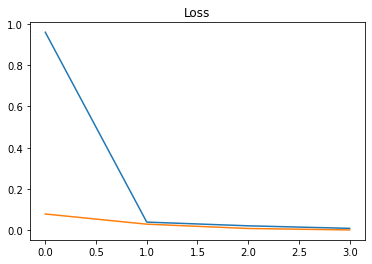

In [27]:
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.show()

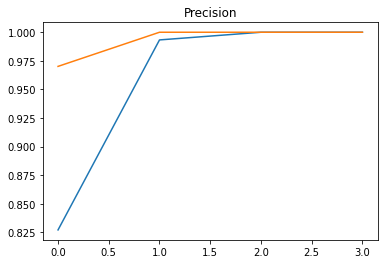

In [28]:
plt.title('Precision')
plt.plot(hist.history['precision'], label='train')
plt.plot(hist.history['val_precision'], label='test')
plt.show()

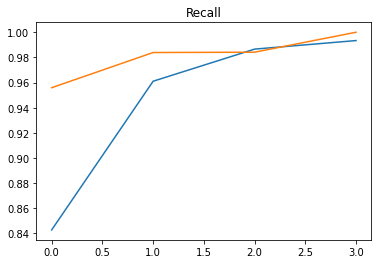

In [29]:
plt.title('Recall')
plt.plot(hist.history['recall'], label='train')
plt.plot(hist.history['val_recall'], label='test')
plt.show()

In [30]:
hist.history

{'loss': [0.9585378170013428,
  0.04026998206973076,
  0.022299358621239662,
  0.010015231557190418],
 'accuracy': [0.15714286267757416,
  0.12678571045398712,
  0.15714286267757416,
  0.16428571939468384],
 'recall': [0.8427672982215881,
  0.9610389471054077,
  0.9865771532058716,
  0.9933775067329407],
 'precision': [0.8271604776382446, 0.9932885766029358, 1.0, 1.0],
 'val_loss': [0.07951953262090683,
  0.030269628390669823,
  0.009426126256585121,
  0.0024920867290347815],
 'val_accuracy': [0.14000000059604645,
  0.1599999964237213,
  0.11599999666213989,
  0.164000004529953],
 'val_recall': [0.9558823704719543,
  0.9838709831237793,
  0.9841269850730896,
  1.0],
 'val_precision': [0.9701492786407471, 1.0, 1.0, 1.0]}

In [31]:
X_test, y_test = test.as_numpy_iterator().next()

In [42]:
y_hat = model.predict(X_test)

1/1 [==============================] - 0s 101ms/step


In [43]:
THRESHOLD = 0.9
y_hat = [1 if y > THRESHOLD else 0 for y in y_hat]

In [44]:
y_test.astype(int), np.array(y_hat)

(array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]),
 array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]))

In [46]:
def predict_wav_file(file_path, threshold=0.9):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=160, frame_step=64)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    return 'Is capuchin' if model.predict(spectrogram) >= threshold else 'Is not capuchin'

In [49]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')
print(predict_wav_file(CAPUCHIN_FILE))
print(predict_wav_file(NOT_CAPUCHIN_FILE))

1/1 [==============================] - 0s 46ms/step
Is capuchin
1/1 [==============================] - 0s 69ms/step
Is not capuchin


In [51]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length=160, frame_step=64)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [52]:
def load_mp3_16k_mono(file_name):
    global sample_rate
    res = tfio.audio.AudioIOTensor(file_name)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1)/2
    old_sample_rate = res.rate
    old_sample_rate = tf.cast(old_sample_rate, tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=old_sample_rate, rate_out=sample_rate)
    return wav

In [53]:
def predict_mp3_file(file_path, threshold=0.9):
    wav = load_mp3_16k_mono(file_path)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    y_hat = model.predict(audio_slices)
    y_hat = [1 if y > threshold else 0 for y in y_hat]
    return y_hat

In [56]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')
y_hat = predict_mp3_file(mp3)
y_hat

1/1 [==============================] - 0s 493ms/step


[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [60]:
# Draw spectrogram with predicted capuchin bird sound parts (green rectangles)

def draw_mp3_spectrogram(file_path, threshold=0.9):
    y_hat = predict_mp3_file(file_path, threshold)
    y, sr = librosa.load(file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(30, 5))
    librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
    for i in range(len(y_hat)):
        if y_hat[i] == 1:
            rect = plt.Rectangle((i*3, 0), 3, plt.ylim()[1], color='g', alpha=0.5, transform=plt.gca().transData, zorder=1)
            plt.gca().add_patch(rect)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    print(plt.xticks())
    plt.show()

1/1 [==============================] - 1s 533ms/step


c:\Python\Python38\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(array([-50.,   0.,  50., 100., 150., 200.]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


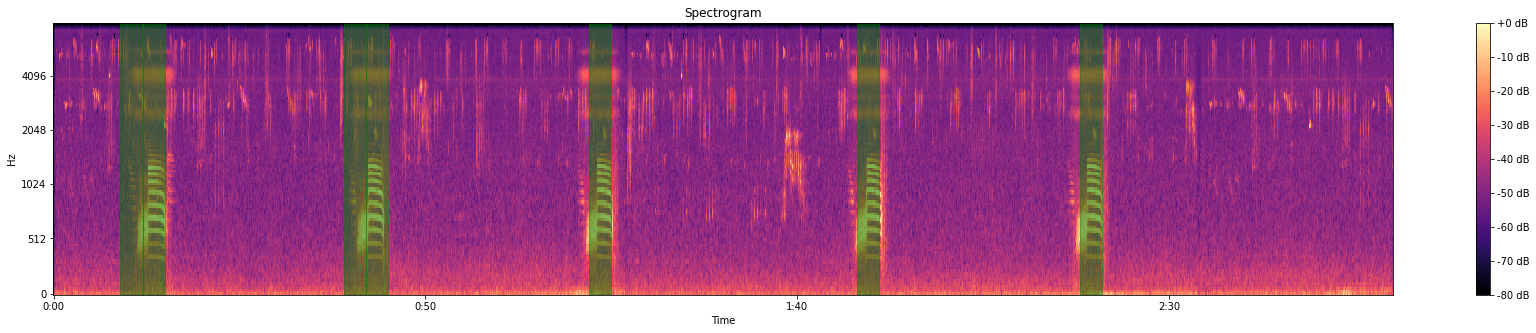

In [61]:
draw_mp3_spectrogram(mp3)

In [62]:
mp3

'data\\Forest Recordings\\recording_00.mp3'

Random forest sound .mp3 file:
1/1 [==============================] - 0s 498ms/step


c:\Python\Python38\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(array([-50.,   0.,  50., 100., 150., 200.]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


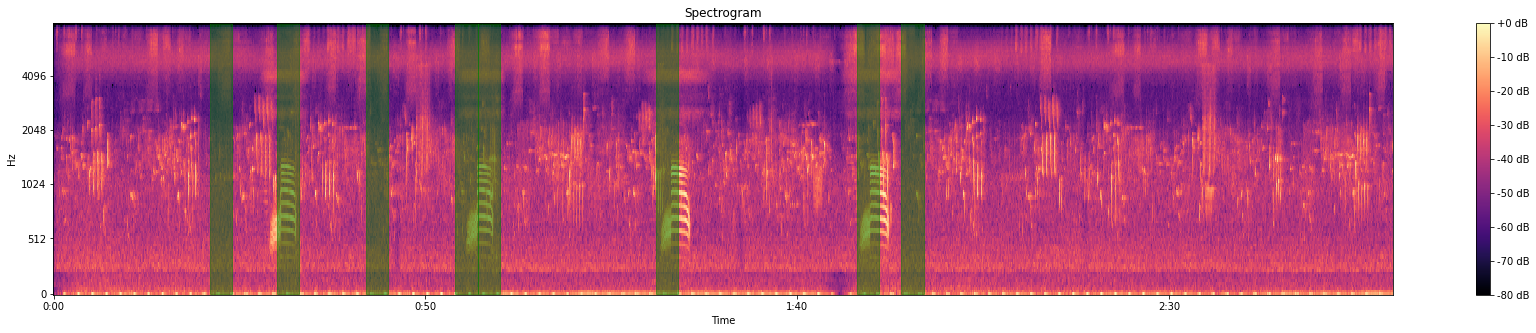

In [77]:
print('Random forest sound .mp3 file:')
FOREST_SOUNDS_PATH = os.path.join('data', 'Forest Recordings')
forest_sounds_files = os.listdir(FOREST_SOUNDS_PATH)
forest_sounds_file = os.path.join('data', 'Forest Recordings', random.choice(forest_sounds_files))
print(forest_sounds_file)
draw_mp3_spectrogram(forest_sounds_file)

In [80]:
def get_number_of_capuchin_sounds(file_path, threshold=0.9):
    y_hat = predict_mp3_file(file_path, threshold)
    y_hat = [key for key, group in groupby(y_hat)]
    return y_hat.count(1)

In [83]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')
print(f'The model predicted that "{mp3}" contains {get_number_of_capuchin_sounds(mp3)} capuchin bird sounds.')

1/1 [==============================] - 1s 501ms/step
The model predicted that "data\Forest Recordings\recording_00.mp3" contains 5 capuchin bird sounds.
